# Simplified Linear Regression for 5‑Day Stock Price Forecast

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt


In [ ]:
def run_linear_regression(csv_file, lag=15, forecast=5):
    # load & sort chronologically
    df = pd.read_csv(csv_file, parse_dates=['Date']).sort_values('Date').reset_index(drop=True)

    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Create lag features
    for i in range(1, lag + 1):
        for col in feature_cols:
            df[f"{col}_lag_{i}"] = df[col].shift(i)

    # Create target (Close price `forecast` days ahead)
    df['target'] = df['Close'].shift(-forecast)

    # Drop rows containing NaNs produced by shifting
    df = df.dropna().reset_index(drop=True)

    X = df[[f"{col}_lag_{i}" for i in range(1, lag + 1) for col in feature_cols]].values
    y = df['target'].values

    # Chronological train / val / test split (70/15/15)
    n = len(df)
    train_end = int(n * 0.70)
    val_end   = int(n * 0.85)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]


    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Fit model to linear regressor and evaluate predictions
    regressor = LinearRegression().fit(X_train_scaled, y_train)

    def _eval(split_name, X_split, y_split):
        y_pred = regressor.predict(X_split)
        mse = mean_squared_error(y_split, y_pred)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_split, y_pred)
        r2 = r2_score(y_split, y_pred)
        return {'Split': split_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    metrics = pd.DataFrame([
        _eval('Train', X_train_scaled, y_train),
        _eval('Validation', X_val_scaled, y_val),
        _eval('Test', X_test_scaled, y_test)
    ])

    # Returns metrics, model, dates, y_test, y_pred
    return metrics, regressor, df.loc[val_end:, 'Date'], y_test, regressor.predict(X_test_scaled)


,Split,MSE,RMSE,MAE,R2
0,Train,8.372598,2.893544,2.067368,0.991325
1,Validation,13.283422,3.644643,2.800462,0.980717
2,Test,52.130585,7.220151,4.491682,0.952609


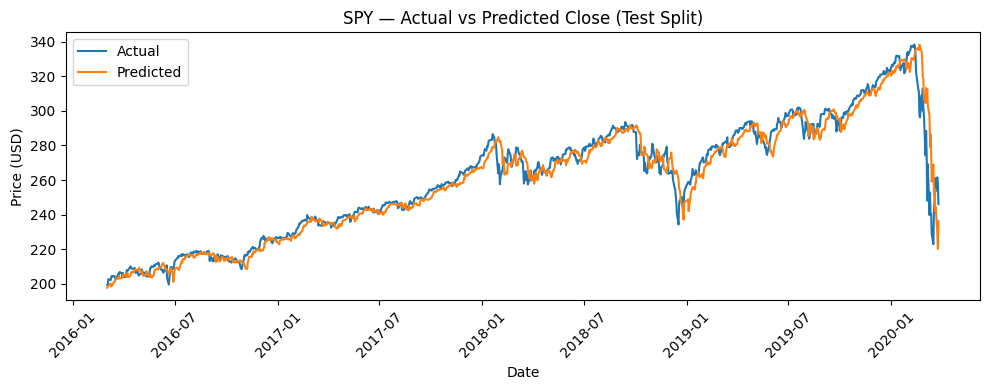

In [6]:
# === Example usage on SPY.csv ===
metrics, fitted_model, test_dates, y_test, y_pred = run_linear_regression('data/etfs/SPY.csv')

display(metrics)

# Plot true vs predicted close prices on the test split
plt.figure(figsize=(10,4))
plt.plot(test_dates, y_test, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.title('SPY — Actual vs Predicted Close (Test Split)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
